# **Import Module**

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import lightgbm as lgb

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error
from sklearn.decomposition import PCA

# ML Model
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense

# **Load Dataset**

In [2]:
dftrn = pd.read_csv('train.csv')
dftes = pd.read_csv('test.csv')
df_train = dftrn.copy().drop(columns="Id")
df_test = dftes.copy().drop(columns="Id")
dftrn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [3]:
set(dftrn.columns).symmetric_difference(set(dftes.columns))

{'SalePrice'}

# Data Handling

## Missing Value

pada pandas versi `2.0.0` data string `NA` dianggap sebagai `NaN` sehingga harus diklarifikasi ulang menggunakan type string bahwa data `NA` adalah bagian dari data kategorikal dan bukan missing value (`NaN`). Bahkan ketika data `NA` telah diubbah menjadi string pandas `2.0.0` tetap menganggapnya sebagai `NaN`, jadi jika dilakukukan drop missing value dengan function `df_train.dropna()` data `NA` yang telah diubah menjadi string tersebut akan ikut terhapus.

In [4]:
missing = pd.DataFrame(df_train.isna().sum(), columns=["jumlah"])
missing[missing["jumlah"]>0]

,jumlah
LotFrontage,259
Alley,1369
MasVnrType,872
MasVnrArea,8
BsmtQual,37
BsmtCond,37
BsmtExposure,38
BsmtFinType1,37
BsmtFinType2,38
Electrical,1


In [5]:
# Train Data
df_train["Alley"] = df_train["Alley"].fillna("NA")
df_train["BsmtQual"] = df_train["BsmtQual"].fillna("NA")
df_train["BsmtCond"] = df_train["BsmtCond"].fillna("NA")
df_train["BsmtExposure"] = df_train["BsmtExposure"].fillna("NA")
df_train["BsmtFinType1"] = df_train["BsmtFinType1"].fillna("NA")
df_train["BsmtFinType2"] = df_train["BsmtFinType2"].fillna("NA")
df_train["FireplaceQu"] = df_train["FireplaceQu"].fillna("NA")
df_train["GarageType"] = df_train["GarageType"].fillna("NA")
df_train["GarageFinish"] = df_train["GarageFinish"].fillna("NA")
df_train["GarageQual"] = df_train["GarageQual"].fillna("NA")
df_train["GarageCond"] = df_train["GarageCond"].fillna("NA")
df_train["PoolQC"] = df_train["PoolQC"].fillna("NA")
df_train["Fence"] = df_train["Fence"].fillna("NA")
df_train["MiscFeature"] = df_train["MiscFeature"].fillna("NA")
df_train["MasVnrType"] = df_train["MasVnrType"].fillna("None")
df_train["Electrical"] = df_train["Electrical"].fillna("NA")
df_train["LotFrontage"] = df_train["LotFrontage"].fillna(0)

In [6]:
# Fill GarageYrBlt with distribution ratio

# Menghitung distribusi GarageYrBlt
proporsi = df_train["GarageYrBlt"].dropna().value_counts(normalize=True)

# target missing value
target = df_train["GarageYrBlt"].isna()

# menghitung jumlah missing value
miss_jumlah = target.sum()

# mengambil sample non-missing value dari GarageYrBlt
replace_value = np.random.choice(proporsi.index,    # index dari proporsi adalah tahun 
                                 size=miss_jumlah,  # jumlah missing value
                                 p=proporsi.values  # nilai proporsi distribusi
                                 )

df_train.loc[target, "GarageYrBlt"] = replace_value

In [7]:
missing = pd.DataFrame(df_test.isna().sum(), columns=["jumlah"])
missing[missing["jumlah"]>0]

,jumlah
MSZoning,4
LotFrontage,227
Alley,1352
Utilities,2
Exterior1st,1
Exterior2nd,1
MasVnrType,894
MasVnrArea,15
BsmtQual,44
BsmtCond,44


In [8]:
# Test Data
df_test["MSZoning"] = df_test["MSZoning"].fillna(df_test["MSZoning"].mode()[0])
df_test["Utilities"] = df_test["Utilities"].fillna(df_test["Utilities"].mode()[0])
df_test["Exterior1st"] = df_test["Exterior1st"].fillna(df_test["Exterior1st"].mode()[0])
df_test["Exterior2nd"] = df_test["Exterior2nd"].fillna(df_test["Exterior2nd"].mode()[0])
df_test["BsmtFinSF1"] = df_test["BsmtFinSF1"].fillna(df_test["BsmtFinSF1"].mode()[0])
df_test["BsmtFinSF2"] = df_test["BsmtFinSF2"].fillna(df_test["BsmtFinSF2"].mode()[0])
df_test["BsmtUnfSF"] = df_test["BsmtUnfSF"].fillna(df_test["BsmtUnfSF"].mode()[0])
df_test["TotalBsmtSF"] = df_test["TotalBsmtSF"].fillna(df_test["TotalBsmtSF"].mode()[0])
df_test["BsmtFullBath"] = df_test["BsmtFullBath"].fillna(df_test["BsmtFullBath"].mode()[0])
df_test["BsmtHalfBath"] = df_test["BsmtHalfBath"].fillna(df_test["BsmtHalfBath"].mode()[0])
df_test["KitchenQual"] = df_test["KitchenQual"].fillna(df_test["KitchenQual"].mode()[0])
df_test["Functional"] = df_test["Functional"].fillna(df_test["Functional"].mode()[0])
df_test["GarageCars"] = df_test["GarageCars"].fillna(df_test["GarageCars"].mode()[0])
df_test["GarageArea"] = df_test["GarageArea"].fillna(df_test["GarageArea"].mode()[0])
df_test["SaleType"] = df_test["SaleType"].fillna(df_test["SaleType"].mode()[0])

df_test["LotFrontage"] = df_test["LotFrontage"].fillna(0)
df_test["Alley"] = df_test["Alley"].fillna("NA")
df_test["MasVnrType"] = df_test["MasVnrType"].fillna("None")
df_test["MasVnrArea"] = df_test["MasVnrArea"].fillna(0)
df_test["BsmtQual"] = df_test["BsmtQual"].fillna("NA")
df_test["BsmtCond"] = df_test["BsmtCond"].fillna("NA")
df_test["BsmtExposure"] = df_test["BsmtExposure"].fillna("NA")
df_test["BsmtFinType1"] = df_test["BsmtFinType1"].fillna("NA")
df_test["BsmtFinType2"] = df_test["BsmtFinType2"].fillna("NA")
df_test["FireplaceQu"] = df_test["FireplaceQu"].fillna("NA")
df_test["GarageType"] = df_test["GarageType"].fillna("NA")
df_test["GarageFinish"] = df_test["GarageFinish"].fillna("NA")
df_test["GarageQual"] = df_test["GarageQual"].fillna("NA")
df_test["GarageCond"] = df_test["GarageCond"].fillna("NA")
df_test["PoolQC"] = df_test["PoolQC"].fillna("NA")
df_test["Fence"] = df_test["Fence"].fillna("NA")
df_test["MiscFeature"] = df_test["MiscFeature"].fillna("NA")


In [9]:
miss = df_test['BsmtFinSF1'].isna()
df_test.loc[miss, 'BsmtFinSF1']

Series([], Name: BsmtFinSF1, dtype: float64)

In [10]:
df_test.loc[df_test['Exterior2nd']=='VinylSd', 'Exterior2nd']

0       VinylSd
2       VinylSd
3       VinylSd
7       VinylSd
15      VinylSd
         ...   
1441    VinylSd
1442    VinylSd
1443    VinylSd
1444    VinylSd
1456    VinylSd
Name: Exterior2nd, Length: 511, dtype: object

In [11]:
# Fill GarageYrBlt with distribution ratio

# Menghitung distribusi GarageYrBlt
proporsi = df_test["GarageYrBlt"].dropna().value_counts(normalize=True)

# target missing value
target = df_test["GarageYrBlt"].isna()

# menghitung jumlah missing value
miss_jumlah = target.sum()

# mengambil sample non-missing value dari GarageYrBlt
replace_value = np.random.choice(proporsi.index,    # index dari proporsi adalah tahun 
                                 size=miss_jumlah,  # jumlah missing value
                                 p=proporsi.values  # nilai proporsi distribusi
                                 )

df_test.loc[target, "GarageYrBlt"] = replace_value

## Kategorikal & Numerikal Data

In [12]:
# Data Waktu
waktu = ["YearBuilt", "YearRemodAdd", "GarageYrBlt", "MoSold", "YrSold"]

# Numerikal Data
numerik = ["LotFrontage", "LotArea", "MasVnrArea", "BsmtFinSF1", "BsmtFinSF2", 
           "BsmtUnfSF", "TotalBsmtSF", "1stFlrSF", "2ndFlrSF", "LowQualFinSF",
           "GrLivArea", "BsmtFullBath", "BsmtHalfBath", "FullBath", "HalfBath",
           "BedroomAbvGr", "KitchenAbvGr", "TotRmsAbvGrd", "Fireplaces",
           "GarageCars", "GarageArea", "WoodDeckSF", "OpenPorchSF", "EnclosedPorch",
           "3SsnPorch", "ScreenPorch", "PoolArea", "MiscVal"]

# Kategorikal Data
kategorik = ["MSSubClass", "MSZoning", "Street", "Alley", "LotShape", "LandContour",
             "Utilities", "LotConfig", "LandSlope", "Neighborhood", "Condition1",
             "Condition2", "BldgType", "HouseStyle", "OverallQual", "OverallCond",
             "RoofStyle", "RoofMatl", "Exterior1st", "Exterior2nd", "MasVnrType",
             "ExterQual", "ExterCond", "Foundation", "BsmtQual", "BsmtCond",
             "BsmtExposure", "BsmtFinType1", "BsmtFinType2", "Heating", "HeatingQC",
             "CentralAir", "Electrical", "KitchenQual", "Functional", "FireplaceQu",
             "GarageType", "GarageFinish", "GarageQual", "GarageCond", "PavedDrive",
             "PoolQC", "Fence", "MiscFeature", "SaleType", "SaleCondition"]

## Categorical Encoding

### Function Value Count

In [13]:
# Cek Value
def CekNilai(string:str):
    """Function ini digunakan untuk mengecek value dari kolom/feature"""
    return df_train[string].value_counts().sort_index()

### Handling Categorical Data

In [14]:
# Handling MSSubClass Train data

df_train.loc[df_train["MSSubClass"]==20, "MSSubClass"] =1
df_train.loc[df_train["MSSubClass"]==30, "MSSubClass"] =2
df_train.loc[df_train["MSSubClass"]==40, "MSSubClass"] =3
df_train.loc[df_train["MSSubClass"]==45, "MSSubClass"] =4
df_train.loc[df_train["MSSubClass"]==50, "MSSubClass"] =5
df_train.loc[df_train["MSSubClass"]==60, "MSSubClass"] =6
df_train.loc[df_train["MSSubClass"]==70, "MSSubClass"] =7
df_train.loc[df_train["MSSubClass"]==75, "MSSubClass"] =8
df_train.loc[df_train["MSSubClass"]==80, "MSSubClass"] =9
df_train.loc[df_train["MSSubClass"]==85, "MSSubClass"] =10
df_train.loc[df_train["MSSubClass"]==90, "MSSubClass"] =11
df_train.loc[df_train["MSSubClass"]==120, "MSSubClass"] =12
df_train.loc[df_train["MSSubClass"]==150, "MSSubClass"] =13
df_train.loc[df_train["MSSubClass"]==160, "MSSubClass"] =14
df_train.loc[df_train["MSSubClass"]==180, "MSSubClass"] =15
df_train.loc[df_train["MSSubClass"]==190, "MSSubClass"] =16

In [15]:
# Handling MSSubClass Test data

df_test.loc[df_test["MSSubClass"]==20, "MSSubClass"] =1
df_test.loc[df_test["MSSubClass"]==30, "MSSubClass"] =2
df_test.loc[df_test["MSSubClass"]==40, "MSSubClass"] =3
df_test.loc[df_test["MSSubClass"]==45, "MSSubClass"] =4
df_test.loc[df_test["MSSubClass"]==50, "MSSubClass"] =5
df_test.loc[df_test["MSSubClass"]==60, "MSSubClass"] =6
df_test.loc[df_test["MSSubClass"]==70, "MSSubClass"] =7
df_test.loc[df_test["MSSubClass"]==75, "MSSubClass"] =8
df_test.loc[df_test["MSSubClass"]==80, "MSSubClass"] =9
df_test.loc[df_test["MSSubClass"]==85, "MSSubClass"] =10
df_test.loc[df_test["MSSubClass"]==90, "MSSubClass"] =11
df_test.loc[df_test["MSSubClass"]==120, "MSSubClass"] =12
df_test.loc[df_test["MSSubClass"]==150, "MSSubClass"] =13
df_test.loc[df_test["MSSubClass"]==160, "MSSubClass"] =14
df_test.loc[df_test["MSSubClass"]==180, "MSSubClass"] =15
df_test.loc[df_test["MSSubClass"]==190, "MSSubClass"] =16

In [16]:
df_test.loc[df_test["BsmtFinSF1"]=='VinylSd', "BsmtFinSF1"] = df_test["BsmtFinSF1"].mode()

In [17]:
# Handling MSZoning

# Mapping MSZoning 1-8 
map_MSZoning = {
    'A': 1,
    'C (all)': 2,
    'FV': 3,
    'I': 4,
    'RH': 5,
    'RM': 6,
    'RL': 7,
    'RP': 8
}

# Train Data
# Mengganti Nilai MSZoning
df_train["MSZoning"] = df_train["MSZoning"].map(map_MSZoning)

# Test Data
# Mengganti Nilai MSZoning
df_test["MSZoning"] = df_test["MSZoning"].map(map_MSZoning)

In [18]:
# Handling Street

# Mapping Street 0-1
map_street = {
    "Grvl" : 1,
    "Pave" : 2
}

# Train Data
# Mengganti Nilai Street
df_train["Street"] = df_train["Street"].map(map_street)

# Test Data
# Mengganti Nilai Street
df_test["Street"] = df_test["Street"].map(map_street)

In [19]:
# Handling Alley

# Mapping Alley 0-2
map_alley = {
    "NA" : 0,
    "Grvl" : 1,
    "Pave" : 2
}

# Train Data
# Mengganti Nilai Alley
df_train["Alley"] = df_train["Alley"].map(map_alley)

# Test Data
# Mengganti Nilai Alley
df_test["Alley"] = df_test["Alley"].map(map_alley)

In [20]:
# Handling LotShape

# Mapping LotShape 1-4
map_LotShape = {
    "Reg" : 4,
    "IR1" : 3,
    "IR2" : 2,
    "IR3" : 1
}

# Train Data
# Menggangi Nilai LotShape
df_train["LotShape"] = df_train["LotShape"].map(map_LotShape)

# Test Data
# Menggangi Nilai LotShape
df_test["LotShape"] = df_test["LotShape"].map(map_LotShape)

In [21]:
# Handling LandContour

# Mapping LandContour 1-4
map_LandContour = {
    "Lvl" : 1,
    "Bnk" : 2,
    "HLS" : 3,
    "Low" : 4
}

# Train Data
# Mengganti Nilai LandContour
df_train["LandContour"] = df_train["LandContour"].map(map_LandContour)

# Test Data
# Mengganti Nilai LandContour
df_test["LandContour"] = df_test["LandContour"].map(map_LandContour)

In [22]:
# Handling Utilities

# Mapping Utilities 1-4
map_Utilities = {
    "AllPub" : 4,
    "NoSewr" : 3,
    "NoSeWa" : 2,
    "ELO"    : 1
}

# Train Data
# Mengganti Nilai Utilities
df_train["Utilities"] = df_train["Utilities"].map(map_Utilities)

# Test Data
# Mengganti Nilai Utilities
df_test["Utilities"] = df_test["Utilities"].map(map_Utilities)

In [23]:
# Handling LotConfig

# Mapping LotConfig 1-5
map_LotConfig = {
    "Inside" : 5,
    "Corner" : 4,
    "CulDSac": 3,
    "FR2"    : 2,
    "FR3"    : 1
}

# Train Data
# Mengganti Nilai LotConfig
df_train["LotConfig"] = df_train["LotConfig"].map(map_LotConfig)

# Test Data
# Mengganti Nilai LotConfig
df_test["LotConfig"] = df_test["LotConfig"].map(map_LotConfig)

In [24]:
# Handling LandSlope

# Mapping LandSlope 1-3
map_LandSlope = {
    "Gtl" : 3,
    "Mod" : 2,
    "Sev" : 1
}

# Train Data
# Mengganti Nilai LandSlope
df_train["LandSlope"] = df_train["LandSlope"].map(map_LandSlope)

# Test Data
# Mengganti Nilai LandSlope
df_test["LandSlope"] = df_test["LandSlope"].map(map_LandSlope)

In [25]:
# Handling Neighborhood

# Mapping Neighborhood 1-25
map_Neighborhood = {
    "Blmngtn" : 1,
    "Blueste" : 2,
    "BrDale"  : 3,
    "BrkSide" : 4,
    "ClearCr" : 5,
    "CollgCr" : 6,
    "Crawfor" : 7,
    "Edwards" : 8,
    "Gilbert" : 9,
    "IDOTRR"  : 10,
    "MeadowV" : 11,
    "Mitchel" : 12,
    "NAmes"   : 13,
    "NoRidge" : 14,
    "NPkVill" : 15,
    "NridgHt" : 16,
    "NWAmes"  : 17,
    "OldTown" : 18,
    "SWISU"   : 19,
    "Sawyer"  : 20,
    "Somerst" : 21,
    "SawyerW" : 22,
    "StoneBr" : 23,
    "Timber"  : 24,
    "Veenker" : 25
}

# Train Data
# Mengganti Nilai Neighborhood
df_train["Neighborhood"] = df_train["Neighborhood"].map(map_Neighborhood)

# Test Data
# Mengganti Nilai Neighborhood
df_test["Neighborhood"] = df_test["Neighborhood"].map(map_Neighborhood)

In [26]:
# Handling Condition1 & Condition2

# Mapping Condition1 1-9
map_Condition1 = {
    "Artery" : 1,
    "Feedr"  : 2,
    "Norm"   : 3,
    "RRNn"   : 4,
    "RRAn"   : 5,
    "PosN"   : 6,
    "PosA"   : 7,
    "RRNe"   : 8,
    "RRAe"   : 9
}

# Train Data
# Mengganti Nilai Condition1
df_train["Condition1"] = df_train["Condition1"].map(map_Condition1)
# Mengganti Nilai Condition2
df_train["Condition2"] = df_train["Condition2"].map(map_Condition1)

# Test Data
# Mengganti Nilai Condition1
df_test["Condition1"] = df_test["Condition1"].map(map_Condition1)
# Mengganti Nilai Condition2
df_test["Condition2"] = df_test["Condition2"].map(map_Condition1)

In [27]:
# Handling BldgType

# Mapping BldgType 1-5
map_BldgType = {
    "1Fam"   : 1,
    "2fmCon" : 2,
    "Duplex" : 3,
    "TwnhsE" : 4,
    "Twnhs"  : 5
}

# Train Data
# Mengganti Nilai BldgType
df_train["BldgType"] = df_train["BldgType"].map(map_BldgType)

# Test Data
# Mengganti Nilai BldgType
df_test["BldgType"] = df_test["BldgType"].map(map_BldgType)

In [28]:
# Handling HouseStyle

# Mapping HouseStyle 1-8
map_HouseStyle = {
    "1Story" : 1,
    "1.5Unf" : 2,
    "1.5Fin" : 3,
    "2Story" : 4,
    "2.5Unf" : 5,
    "2.5Fin" : 6,
    "SFoyer" : 7,
    "SLvl"   : 8
}

# Train Data
# Mengganti Nilai HouseStyle
df_train["HouseStyle"] = df_train["HouseStyle"].map(map_HouseStyle)

# Test Data
# Mengganti Nilai HouseStyle
df_test["HouseStyle"] = df_test["HouseStyle"].map(map_HouseStyle)

In [29]:
# Handling RoofStyle

# Mapping RoofStyle 1-6
map_RoofStyle = {
    "Flat"    : 1,
    "Gable"   : 2, 
    "Gambrel" : 3,
    "Hip"     : 4,
    "Mansard" : 5,
    "Shed"    : 6,
}

# Train Data
# Mengganti Nilai RoofStylez
df_train["RoofStyle"] = df_train["RoofStyle"].map(map_RoofStyle)

# Test Data
# Mengganti Nilai RoofStylez
df_test["RoofStyle"] = df_test["RoofStyle"].map(map_RoofStyle)

In [30]:
# Handling RoofMatl

# Mapping RoofMatl 1-8
map_RoofMatl = {
    "ClyTile" : 1,
    "CompShg" : 2,
    "Membran" : 3,
    "Metal"   : 4,
    "Roll"    : 5,
    "Tar&Grv" : 6,
    "WdShake" : 7,
    "WdShngl" : 8
}

# Train Data
# Mengganti Nilai RoofMatl
df_train["RoofMatl"] = df_train["RoofMatl"].map(map_RoofMatl)

# Test Data
# Mengganti Nilai RoofMatl
df_test["RoofMatl"] = df_test["RoofMatl"].map(map_RoofMatl)

In [31]:
# Handling Exterior1st & Exterior2nd

# Mapping Exterior1st 1-17
map_Exterior1st = {
    "AsbShng" : 1,
    "AsphShn" : 2,
    "BrkComm" : 3,
    "Brk Cmn" : 3,
    "BrkFace" : 4,
    "CBlock"  : 5,
    "CemntBd" : 6,
    "CmentBd" : 6,
    "HdBoard" : 7,
    "ImStucc" : 8,
    "MetalSd" : 9,
    "Other"   : 10,
    "Plywood" : 11,
    "PreCast" : 12,
    "Stone"   : 13,
    "Stucco"  : 14,
    "VinylSd" : 15,
    "Wd Sdng" : 16,
    "WdShing" : 17,
    "Wd Shng" : 17,
}

# Train Data
# Mengganti Nilai Exterior1st
df_train["Exterior1st"] = df_train["Exterior1st"].map(map_Exterior1st)
# Mengganti Nilai Exterior2nd
df_train["Exterior2nd"] = df_train["Exterior2nd"].map(map_Exterior1st)

# Test Data
# Mengganti Nilai Exterior1st
df_test["Exterior1st"] = df_test["Exterior1st"].map(map_Exterior1st)
# Mengganti Nilai Exterior2nd
df_test["Exterior2nd"] = df_test["Exterior2nd"].map(map_Exterior1st)

In [32]:
# Handling MasVnrType

# Mapping MasVnrType 0-4
map_MasVnrType = {
    "None"   : 0,
    "BrkCmn" : 1,
    "BrkFace": 2,
    "CBlok"  : 3,
    "Stone"  : 4
}

# Train Data
# Mengganti Nilai MasVnrType
df_train["MasVnrType"] = df_train["MasVnrType"].map(map_MasVnrType)

# Test Data
# Mengganti Nilai MasVnrType
df_test["MasVnrType"] = df_test["MasVnrType"].map(map_MasVnrType)

In [33]:
# Handling ExterQual, ExterCond, HeatingQC, KitchenQual

# Mapping ExterQual 0-4
map_ExterQual = {
    "Po" : 0,
    "Fa" : 1,
    "TA" : 2,
    "Gd" : 3,
    "Ex" : 4
}

# Train Data
# Mengganti Nilai ExterQual
df_train["ExterQual"] = df_train["ExterQual"].map(map_ExterQual)
# Mengganti Nilai ExterCond
df_train["ExterCond"] = df_train["ExterCond"].map(map_ExterQual)
# Mengganti Nilai HeatingQC
df_train["HeatingQC"] = df_train["HeatingQC"].map(map_ExterQual)
# Mengganti Nilai KitchenQual
df_train["KitchenQual"] = df_train["KitchenQual"].map(map_ExterQual)

# Test Data
# Mengganti Nilai ExterQual
df_test["ExterQual"] = df_test["ExterQual"].map(map_ExterQual)
# Mengganti Nilai ExterCond
df_test["ExterCond"] = df_test["ExterCond"].map(map_ExterQual)
# Mengganti Nilai HeatingQC
df_test["HeatingQC"] = df_test["HeatingQC"].map(map_ExterQual)
# Mengganti Nilai KitchenQual
df_test["KitchenQual"] = df_test["KitchenQual"].map(map_ExterQual)

In [34]:
# Handling Foundation

# Mapping Foundation 1-6
map_Foundation = {
    "Wood"  : 1,
    "Stone" : 2,
    "Slab"  : 3,
    "PConc" : 4,
    "CBlock": 5,
    "BrkTil": 6
}

# Train Data
# Mengganti Nilai Foundation
df_train["Foundation"] = df_train["Foundation"].map(map_Foundation)

# Test Data
# Mengganti Nilai Foundation
df_test["Foundation"] = df_test["Foundation"].map(map_Foundation)

In [35]:
# Handling BsmtQual, map_BsmtQual & FireplaceQu

# Mapping BsmtQual 0-5
map_BsmtQual = {
    "NA" : 0,
    "Po" : 1,
    "Fa" : 2,
    "TA" : 3,
    "Gd" : 4,
    "Ex" : 5
}

# Train Data
# Mengganti Nilai BsmtQual
df_train["BsmtQual"] = df_train["BsmtQual"].map(map_BsmtQual)
# Mengganti Nilai BsmtCond
df_train["BsmtCond"] = df_train["BsmtCond"].map(map_BsmtQual)
# Mengganti Nilai FireplaceQu
df_train["FireplaceQu"] = df_train["FireplaceQu"].map(map_BsmtQual)
# Mengganti Nilai GarageQual
df_train["GarageQual"] = df_train["GarageQual"].map(map_BsmtQual)
# Mengganti Nilai GarageCond
df_train["GarageCond"] = df_train["GarageCond"].map(map_BsmtQual)
# Mengganti Nilai PoolQC
df_train["PoolQC"] = df_train["PoolQC"].map(map_BsmtQual)

# Test Data
# Mengganti Nilai BsmtQual
df_test["BsmtQual"] = df_test["BsmtQual"].map(map_BsmtQual)
# Mengganti Nilai BsmtCond
df_test["BsmtCond"] = df_test["BsmtCond"].map(map_BsmtQual)
# Mengganti Nilai FireplaceQu
df_test["FireplaceQu"] = df_test["FireplaceQu"].map(map_BsmtQual)
# Mengganti Nilai GarageQual
df_test["GarageQual"] = df_test["GarageQual"].map(map_BsmtQual)
# Mengganti Nilai GarageCond
df_test["GarageCond"] = df_test["GarageCond"].map(map_BsmtQual)
# Mengganti Nilai PoolQC
df_test["PoolQC"] = df_test["PoolQC"].map(map_BsmtQual)

In [36]:
# Handling BsmtExposure

# Mapping BsmtExposure 0-4
map_BsmtExposure = {
    "NA" : 0,
    "No" : 1,
    "Mn" : 2,
    "Av" : 3,
    "Gd" : 4
}

# Train Data
# Mengganti Nilai BsmtExposure
df_train["BsmtExposure"] = df_train["BsmtExposure"].map(map_BsmtExposure)

# Test Data
# Mengganti Nilai BsmtExposure
df_test["BsmtExposure"] = df_test["BsmtExposure"].map(map_BsmtExposure)

In [37]:
# Handling BsmtFinType1 & BsmtFinType2

# Mapping BsmtFinType1 0-6
map_BsmtFinType1 = {
    "NA"  : 0,
    "Unf" : 1,
    "LwQ" : 2,
    "Rec" : 3,
    "BLQ" : 4,
    "ALQ" : 5,
    "GLQ" : 6
}

# Train Data
# Mengganti Nilai BsmtFinType1
df_train["BsmtFinType1"] = df_train["BsmtFinType1"].map(map_BsmtFinType1)
# Mengganti Nilai BsmtFinType2
df_train["BsmtFinType2"] = df_train["BsmtFinType2"].map(map_BsmtFinType1)

# Test Data
# Mengganti Nilai BsmtFinType1
df_test["BsmtFinType1"] = df_test["BsmtFinType1"].map(map_BsmtFinType1)
# Mengganti Nilai BsmtFinType2
df_test["BsmtFinType2"] = df_test["BsmtFinType2"].map(map_BsmtFinType1)


In [38]:
# Handling Heating

# Mapping Heating 1-6
map_Heating = {
    "Floor" : 1,
    "GasA"  : 2,
    "GasW"  : 3,
    "Grav"  : 4,
    "OthW"  : 5,
    "Wall"  : 6
}

# Train Data
# Mengganti Nilai Heating
df_train["Heating"] = df_train["Heating"].map(map_Heating)

# Test Data
# Mengganti Nilai Heating
df_test["Heating"] = df_test["Heating"].map(map_Heating)

In [39]:
# Handling CentralAir

# Mapping CentralAir 0-1
map_CentralAir = {
    "N" : 0,
    "Y" : 1
}

# Train Data
# Mengganti Nilai CentralAir
df_train["CentralAir"] = df_train["CentralAir"].map(map_CentralAir)

# Test Data
# Mengganti Nilai CentralAir
df_test["CentralAir"] = df_test["CentralAir"].map(map_CentralAir)

In [40]:
# Handling Electrical

# Mapping Electrical 1-5
map_Electrical = {
    "NA"    : 0,
    "SBrkr" : 1,
    "FuseA" : 2,
    "FuseF" : 3,
    "FuseP" : 4,
    "Mix"   : 5
}

# Train Data
# Mengganti Nilai Electrical
df_train["Electrical"] = df_train["Electrical"].map(map_Electrical)

# Test Data
# Mengganti Nilai Electrical
df_test["Electrical"] = df_test["Electrical"].map(map_Electrical)

In [41]:
# Handling Functional

# Mapping Functional 1-8
map_Functional = {
    "Typ"  : 1,
    "Min1" : 2,
    "Min2" : 3,
    "Mod"  : 4,
    "Maj1" : 5,
    "Maj2" : 6,
    "Sev"  : 7,
    "Sal"  : 8
}

# Train Data 
# Mengganti Nilai Functional
df_train["Functional"] = df_train["Functional"].map(map_Functional)

# Test Data
# Mengganti Nilai Functional
df_test["Functional"] = df_test["Functional"].map(map_Functional)

In [42]:
# Handling GarageType

# Mapping GarageType 0-6
map_GarageType = {
    "2Types" : 6,
    "Attchd" : 5,
    "Basment": 4,
    "BuiltIn": 3,
    "CarPort": 2,
    "Detchd" : 1,
    "NA"     : 0
}

# Train Data
# Mengganti Nilai GarageType
df_train["GarageType"] = df_train["GarageType"].map(map_GarageType)

# Test Data
# Mengganti Nilai GarageType
df_test["GarageType"] = df_test["GarageType"].map(map_GarageType)

In [43]:
# Handling GarageFinish

# Mapping GarageFinish 0-3
map_GarageFinish = {
    "Fin" : 3,
    "RFn" : 2,
    "Unf" : 1,
    "NA"  : 0
}

# Train Data
# Mengganti Nilai GarageFinish
df_train["GarageFinish"] = df_train["GarageFinish"].map(map_GarageFinish)

# Test Data
# Mengganti Nilai GarageFinish
df_test["GarageFinish"] = df_test["GarageFinish"].map(map_GarageFinish)

In [44]:
# Handling PavedDrive

# Mapping PavedDrive 0-2
map_PavedDrive = {
    "Y" : 2,
    "P" : 1,
    "N" : 0
}

# Train Data
# Mengganti Nilai PavedDrive
df_train["PavedDrive"] = df_train["PavedDrive"].map(map_PavedDrive)

# Test Data
# Mengganti Nilai PavedDrive
df_test["PavedDrive"] = df_test["PavedDrive"].map(map_PavedDrive)

In [45]:
# Handling Fence

# Mapping Fence 0-4
map_Fence = {
    "NA"   : 0,
    "MnWw" : 1,
    "GdWo" : 2,
    "MnPrv": 3,
    "GdPrv": 4
}

# Train Data 
# Mengganti Nilai Fence
df_train["Fence"] = df_train["Fence"].map(map_Fence)

# Test Data
# Mengganti Nilai Fence
df_test["Fence"] = df_test["Fence"].map(map_Fence)

In [46]:
# Handling MiscFeature

# Mapping MiscFeature 0-5
map_MiscFeature = {
    "NA"   : 0,
    "TenC" : 1,
    "Shed" : 2,
    "Othr" : 3,
    "Gar2" : 4,
    "Elev" : 5
}

# Train Data
# Mengganti Nilai MiscFeature
df_train["MiscFeature"] = df_train["MiscFeature"].map(map_MiscFeature)

# Test Data
# Mengganti Nilai MiscFeature
df_test["MiscFeature"] = df_test["MiscFeature"].map(map_MiscFeature)

In [47]:
# Handling SaleType

# Mapping SaleType 1-10
map_SaleType = {
    "WD"    : 1,
    "CWD"   : 2,
    "VWD"   : 3,
    "New"   : 4,
    "COD"   : 5,
    "Con"   : 6,
    "ConLw" : 7,
    "ConLI" : 8,
    "ConLD" : 9,
    "Oth"   : 10
}

# Train Data
# Mengganti Nilai SaleType
df_train["SaleType"] = df_train["SaleType"].map(map_SaleType)

# Test Data
# Mengganti Nilai SaleType
df_test["SaleType"] = df_test["SaleType"].map(map_SaleType)

In [48]:
# Handling SaleCondition

# Mapping SaleCondition 1-6
map_SaleCondition = {
    "Normal"  : 1,
    "Abnorml" : 2,
    "AdjLand" : 3,
    "Alloca"  : 4,
    "Family"  : 5,
    "Partial" : 6
}

# Train Data
# Mengganti Nilai SaleCondition
df_train["SaleCondition"] = df_train["SaleCondition"].map(map_SaleCondition)

# Test Data
# Mengganti Nilai SaleCondition
df_test["SaleCondition"] = df_test["SaleCondition"].map(map_SaleCondition)

In [49]:
# Menghitung missing value
data = pd.DataFrame(df_train.isna().sum(), columns=["jumlah"])
data[data['jumlah']>0]

,jumlah
MasVnrArea,8


In [50]:
df_test[['BsmtFinSF1']].value_counts().sort_index()

BsmtFinSF1
0.0           463
16.0            5
20.0            3
24.0           15
28.0            2
             ... 
2146.0          1
2158.0          1
2257.0          1
2288.0          1
4010.0          1
Name: count, Length: 669, dtype: int64

In [51]:
# Drop Missing Value
df_train.dropna(inplace=True)
# df_test.dropna(inplace=True)

# Mengganti data type dari float ke int
df_train["MasVnrArea"] = df_train["MasVnrArea"].astype(dtype=int)
df_train["LotFrontage"] = df_train["LotFrontage"].astype(dtype=int)
df_train["GarageYrBlt"] = df_train["GarageYrBlt"].astype(dtype=int)

# Analisis

In [52]:
print("data berbentuk waktu")
print(*waktu, "\n")
print("data berbentuk numerik")
print(*numerik, "\n")
print("data berbentuk kategorik")
print(*kategorik) 

data berbentuk waktu
YearBuilt YearRemodAdd GarageYrBlt MoSold YrSold 

data berbentuk numerik
LotFrontage LotArea MasVnrArea BsmtFinSF1 BsmtFinSF2 BsmtUnfSF TotalBsmtSF 1stFlrSF 2ndFlrSF LowQualFinSF GrLivArea BsmtFullBath BsmtHalfBath FullBath HalfBath BedroomAbvGr KitchenAbvGr TotRmsAbvGrd Fireplaces GarageCars GarageArea WoodDeckSF OpenPorchSF EnclosedPorch 3SsnPorch ScreenPorch PoolArea MiscVal 

data berbentuk kategorik
MSSubClass MSZoning Street Alley LotShape LandContour Utilities LotConfig LandSlope Neighborhood Condition1 Condition2 BldgType HouseStyle OverallQual OverallCond RoofStyle RoofMatl Exterior1st Exterior2nd MasVnrType ExterQual ExterCond Foundation BsmtQual BsmtCond BsmtExposure BsmtFinType1 BsmtFinType2 Heating HeatingQC CentralAir Electrical KitchenQual Functional FireplaceQu GarageType GarageFinish GarageQual GarageCond PavedDrive PoolQC Fence MiscFeature SaleType SaleCondition


## Cek Outliers

In [53]:
num1, num2 = numerik[0:14], numerik[14:]

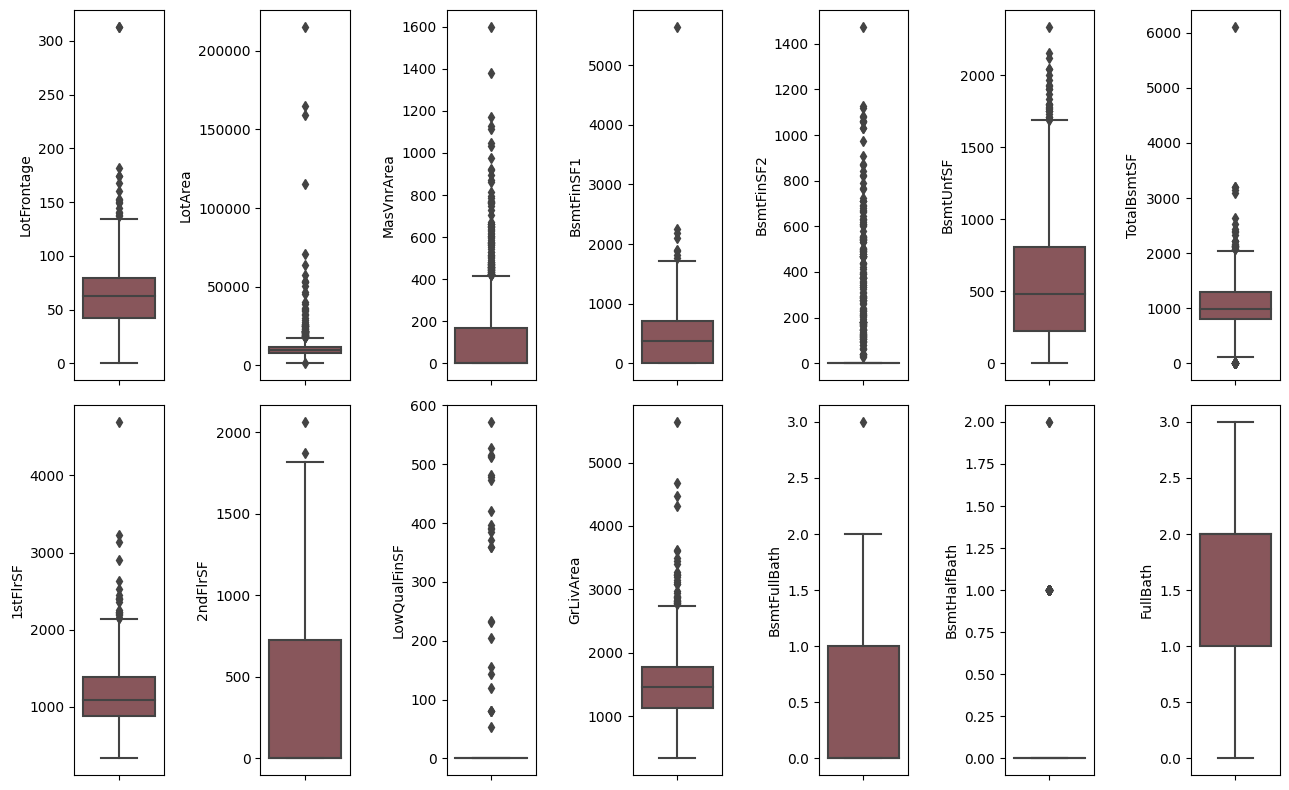

In [54]:
figura = plt.figure(figsize=(13,8))

for i in range(0, len(num1)):
    plt.subplot(2, 7, i+1)
    sns.boxplot(y=df_train[num1[i]], color='#904E55')
    plt.tight_layout()

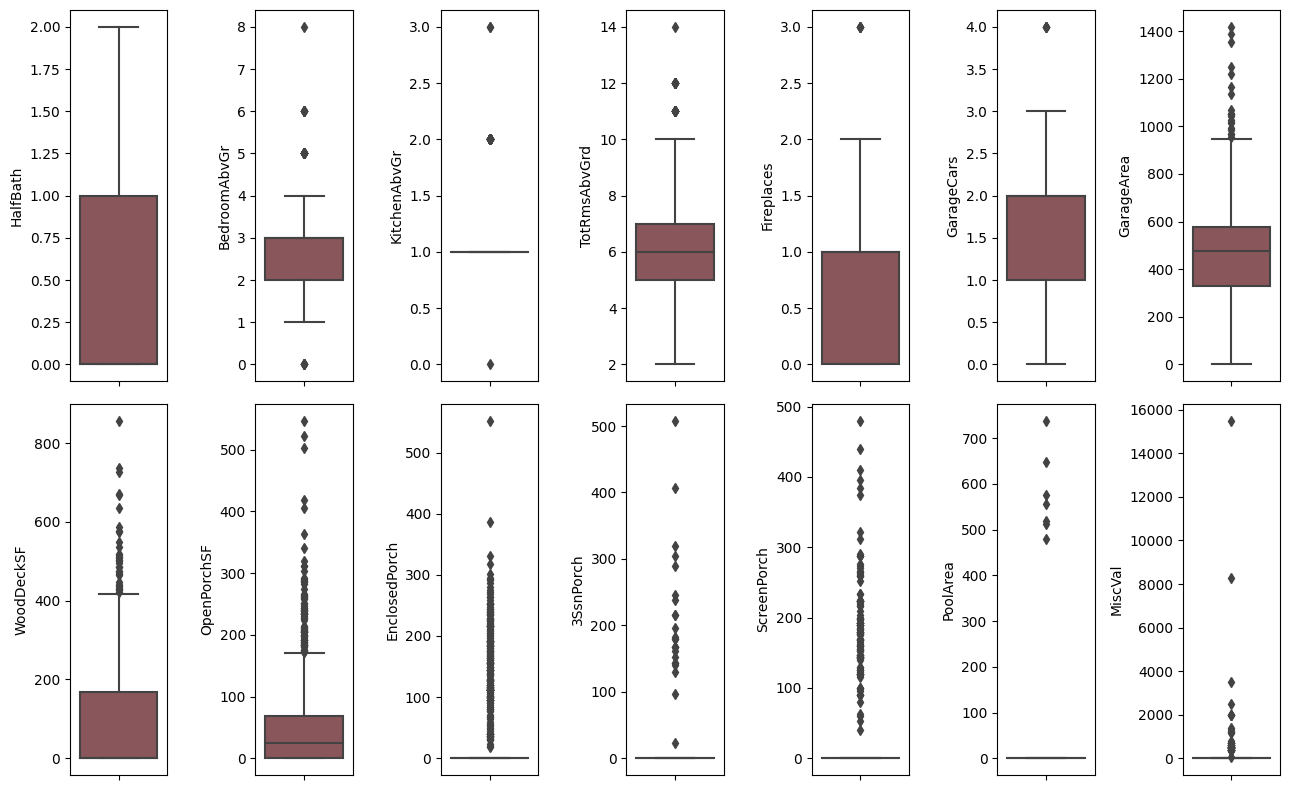

In [55]:
figura = plt.figure(figsize=(13,8))

for i in range(0, len(num2)):
    plt.subplot(2, 7, i+1)
    sns.boxplot(y=df_train[num2[i]], color='#904E55')
    plt.tight_layout()

## Multivariat Analisis

In [60]:
data_train = pd.concat([df_train, 
                        df_train])
corr = data_train.corr()
corr

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
MSSubClass,1.000000,-0.228905,-0.198645,-0.132423,-0.026253,0.152735,0.097846,-0.022780,0.025826,0.024085,...,0.018945,0.025885,-0.075208,-0.033670,-0.006066,0.003077,-0.022244,-0.009627,-0.040347,-0.061068
MSZoning,-0.228905,1.000000,0.070191,0.146704,0.098467,-0.416581,-0.159067,0.018176,-0.010403,-0.064808,...,0.027295,0.026319,0.069958,0.013653,0.018863,-0.009816,-0.006611,-0.102720,-0.108214,0.093162
LotFrontage,-0.198645,0.070191,1.000000,0.102882,-0.025167,-0.054906,0.111360,-0.000363,0.043686,0.135214,...,0.114458,0.150725,0.008561,-0.044615,-0.059832,0.015736,-0.010251,0.104442,0.180374,0.208386
LotArea,-0.132423,0.146704,0.102882,1.000000,-0.197573,-0.082047,-0.315423,0.340041,-0.010168,-0.128110,...,0.077888,0.091968,-0.041077,0.103937,0.038226,0.003203,-0.012977,-0.003856,0.011599,0.264674
Street,-0.026253,0.098467,-0.025167,-0.197573,1.000000,0.015604,0.010050,-0.103863,-0.001691,-0.006939,...,0.004437,0.004278,0.030369,-0.146660,-0.022703,0.003617,-0.025113,-0.039889,0.003214,0.040982
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
MoSold,0.003077,-0.009816,0.015736,0.003203,0.003617,-0.027869,-0.027154,0.054067,0.051734,0.023917,...,-0.033785,-0.032442,-0.003768,0.014520,-0.006400,1.000000,-0.145367,0.069463,0.078176,0.045136
YrSold,-0.022244,-0.006611,-0.010251,-0.012977,-0.025113,-0.009826,0.035911,-0.025571,-0.023409,-0.012510,...,-0.059800,-0.050383,0.048316,0.056134,0.004938,-0.145367,1.000000,-0.047223,-0.140092,-0.026180
SaleType,-0.009627,-0.102720,0.104442,-0.003856,-0.039889,-0.004497,-0.008451,-0.004936,-0.067474,0.003637,...,-0.006522,-0.001233,-0.059375,0.011169,-0.017463,0.069463,-0.047223,1.000000,0.540893,0.147800
SaleCondition,-0.040347,-0.108214,0.180374,0.011599,0.003214,0.017202,-0.026360,0.026881,-0.007660,0.042385,...,0.039416,0.047312,-0.113618,-0.061293,-0.033313,0.078176,-0.140092,0.540893,1.000000,0.289183


In [61]:
fillternih1 = corr['SalePrice']<=0.1
fillternih2 = corr['SalePrice']>=-0.1
len(df_train.columns) - len(corr[fillternih1 & fillternih2].index)

56

# Feature Selection

## Corelation Feature Selection

In [97]:
cor_train = df_train[corr[fillternih1 & fillternih2].index.to_list() + ["SalePrice"]]
                                   
cor_test = df_test[corr[fillternih1 & fillternih2].index.to_list()]

# Data Scaling

In [63]:
fitur = df_train.drop(columns=["SalePrice"])
target = df_train[["SalePrice"]]

In [64]:
# Min-Max Scaler
minmax = MinMaxScaler()
MMscale_train = minmax.fit_transform(fitur)
MMscale_test = minmax.fit_transform(df_test)

MMcor_train = minmax.fit_transform(cor_train)
MMcor_test = minmax.fit_transform(cor_test)

# Standard Scaler
std = StandardScaler()
std_train = std.fit_transform(fitur)
std_test = std.fit_transform(df_test)

stdcor_train = std.fit_transform(cor_train)
stdcor_test = std.fit_transform(cor_test)

# PCA Reduction Matrics

In [65]:
pca1 = PCA(n_components=0.95)  # Menentukan jumlah komponen utama berdasarkan variansi yang dijelaskan (contoh: 95%)
pca_train = pca1.fit_transform(MMscale_train)

pca2 = PCA(n_components=len(pca1.explained_variance_ratio_))
pca_test = pca2.fit_transform(MMscale_test)

# Split Data

In [66]:
(X_train, X_test,
 Y_train, Y_test) = train_test_split(cor_train, target,
                                     test_size=0.25,
                                     random_state=42)

In [67]:
len(X_train.columns)

56

# Machine Learning Model

## Linear Regresi

In [68]:
simple_reg = LinearRegression()

simple_reg.fit(X_train, Y_train)

LinearRegression()

In [69]:
coef_df = pd.DataFrame({
    'feature':['intercept'] + X_train.columns.tolist(),
    'coefficient':[simple_reg.intercept_] + list(simple_reg.coef_[0])
})

coef_df.head(15)

,feature,coefficient
0,intercept,[-260932.76287012897]
1,LotFrontage,-46.059602
2,LotArea,0.281508
3,LotShape,586.035988
4,Neighborhood,403.029364
5,BldgType,-6938.636527
6,OverallQual,11562.602705
7,YearBuilt,51.119163
8,YearRemodAdd,78.501141
9,RoofStyle,3624.940762


## Random Forest

In [70]:
# Model ML
randomforest = RandomForestRegressor(random_state=42)

# Parameter yang akan diuji
rf_parameters = {
    'n_estimators': (5, 10, 20, 30, 50, 80, 100),
    'min_samples_leaf': (2, 3, 4, 5, 8, 10)
}

# Grid Search CV Tuning
rf_gridcv = GridSearchCV(randomforest, rf_parameters, cv=5, 
                         scoring='neg_root_mean_squared_error')
rf_gridcv.fit(X_train, Y_train)

c:\Users\M. Wahid Mudzakir\anaconda3\envs\main_project\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\M. Wahid Mudzakir\anaconda3\envs\main_project\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\M. Wahid Mudzakir\anaconda3\envs\main_project\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\M. Wahid Mudzakir\anaconda3\env

c:\Users\M. Wahid Mudzakir\anaconda3\envs\main_project\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\M. Wahid Mudzakir\anaconda3\envs\main_project\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\M. Wahid Mudzakir\anaconda3\envs\main_project\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\M. Wahid Mudzakir\anaconda3\env

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42),
             param_grid={'min_samples_leaf': (2, 3, 4, 5, 8, 10),
                         'n_estimators': (5, 10, 20, 30, 50, 80, 100)},
             scoring='neg_root_mean_squared_error')

In [71]:
rfmodel = pd.DataFrame(rf_gridcv.cv_results_)
rfmodel.sort_values('rank_test_score').head(5)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_min_samples_leaf,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
6,0.867171,0.011184,0.011530,0.000871,2,100,"{'min_samples_leaf': 2, 'n_estimators': 100}",-33383.197524,-33041.097310,-34266.327046,-31161.535536,-28606.040134,-32091.639510,2015.606832,1
5,0.702874,0.017668,0.009572,0.000582,2,80,"{'min_samples_leaf': 2, 'n_estimators': 80}",-34261.222370,-33259.958597,-34228.846098,-30697.903767,-28345.179631,-32158.622093,2306.327769,2
4,0.430675,0.004046,0.006967,0.000334,2,50,"{'min_samples_leaf': 2, 'n_estimators': 50}",-34211.284780,-34384.869564,-33431.017384,-30582.520283,-28268.886066,-32175.715615,2383.328513,3
3,0.259457,0.002878,0.005933,0.000341,2,30,"{'min_samples_leaf': 2, 'n_estimators': 30}",-35891.497230,-34179.615525,-33288.692089,-31242.377866,-29012.522101,-32722.940962,2384.994723,4
19,0.561445,0.017917,0.008825,0.000431,4,80,"{'min_samples_leaf': 4, 'n_estimators': 80}",-34842.401668,-33827.132540,-36712.269407,-30521.827144,-28670.477379,-32914.821628,2922.648332,5


## XG-Boost

In [72]:
# ML Model
xgb = XGBRegressor()

# Parameter yang akan diuji
xgb_parameters = {'gamma': [0, 1, 2, 5, 10, 20, 50], 
                  'learning_rate': [0.01, 0.1, 0.2, 0.5, 1],
                  'subsample': [0.3, 0.5, 0.7, 1]}

# Grid Search CV Tuning
xgb_gridcv = GridSearchCV(xgb, xgb_parameters, cv=5, 
                          scoring='neg_root_mean_squared_error')

xgb_gridcv.fit(X_train, Y_train)

GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None, gpu_id=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None, n_estimators=100,
                                    n_jobs=None, num_parallel_tree=None,
                                    predictor=None, random_state=None, ...),
             param_grid={'gamma': [0, 1, 2, 5, 10, 20, 50],
                         'learning_rate': [0.01, 0.1, 0.2, 0.5, 1],
                         'subsample': [0.3, 0.5, 0.7, 1]},
             scoring='neg_root_mean_squared_error')

In [73]:
xgbmodel = pd.DataFrame(xgb_gridcv.cv_results_)
xgbmodel.sort_values('rank_test_score').head(5)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_gamma,param_learning_rate,param_subsample,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
86,0.118455,0.001804,0.005799,0.000401,10,0.1,0.7,"{'gamma': 10, 'learning_rate': 0.1, 'subsample...",-39487.963106,-31106.656302,-28115.700609,-28951.42794,-26687.144877,-30869.778567,4540.675168,1
46,0.110601,0.001497,0.005600,0.000490,2,0.1,0.7,"{'gamma': 2, 'learning_rate': 0.1, 'subsample'...",-39487.963106,-31106.656302,-28115.700609,-28951.42794,-26687.144877,-30869.778567,4540.675168,1
6,0.112142,0.001627,0.005551,0.000561,0,0.1,0.7,"{'gamma': 0, 'learning_rate': 0.1, 'subsample'...",-39487.963106,-31106.656302,-28115.700609,-28951.42794,-26687.144877,-30869.778567,4540.675168,1
106,0.111599,0.001356,0.006001,0.000002,20,0.1,0.7,"{'gamma': 20, 'learning_rate': 0.1, 'subsample...",-39487.963106,-31106.656302,-28115.700609,-28951.42794,-26687.144877,-30869.778567,4540.675168,1
26,0.110601,0.000801,0.005799,0.000398,1,0.1,0.7,"{'gamma': 1, 'learning_rate': 0.1, 'subsample'...",-39487.963106,-31106.656302,-28115.700609,-28951.42794,-26687.144877,-30869.778567,4540.675168,1


In [74]:
xgb_gridcv.best_params_

{'gamma': 0, 'learning_rate': 0.1, 'subsample': 0.7}

## Neural Network

In [75]:
# Fungsi untuk membuat model KerasRegressor
def create_regressor_model( units=32, dropout_rate=0.0, optimizer='adam', input_dim=len(cor_train.columns), evaluasi=['mse', 'mae']):
    """
    fungsi ini digunakan untuk membuat model neural network

    `units` : int | merupakan jumlah dense unit atau hiden layer dalam model neural network\n
    `dropout_rate` : float |\n
    `optimizer` : str | adam atau std\n
    `input_dim` : int | merupakan panjang dari feature\n
    `evaluasi` : list | 

    """

    # Model Layers
    model = Sequential()
    model.add(Dense(units, activation='relu', input_shape=(input_dim,)))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation='linear'))
    model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=evaluasi)
    return model

In [76]:
# Membuat model KerasRegressor
NN_model = KerasRegressor(build_fn=create_regressor_model)

C:\Users\M. Wahid Mudzakir\AppData\Local\Temp\ipykernel_19416\1744302030.py:2: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  NN_model = KerasRegressor(build_fn=create_regressor_model)


In [77]:
param_grid = {'epochs': [10, 15, 20, 25],
              'dropout_rate': [0.0, 0.2, 0.5],
              #'optimizer': ['adam', 'sgd'],
              'units': [32, 64],
              'batch_size': [32]
}

NN_gridcv = GridSearchCV(estimator=NN_model, param_grid=param_grid, scoring='neg_mean_squared_error', cv=5)

In [78]:
NN_gridcv.fit(X_train, Y_train)

Epoch 1/10
28/28 [==============================] - 1s 3ms/step - loss: 38645309440.0000 - mse: 38645309440.0000 - mae: 179858.9375
Epoch 2/10
28/28 [==============================] - 0s 3ms/step - loss: 37536534528.0000 - mse: 37536534528.0000 - mae: 176965.9844
Epoch 3/10
28/28 [==============================] - 0s 3ms/step - loss: 36294971392.0000 - mse: 36294971392.0000 - mae: 173645.9688
Epoch 4/10
28/28 [==============================] - 0s 3ms/step - loss: 34799124480.0000 - mse: 34799124480.0000 - mae: 169565.1719
Epoch 5/10
28/28 [==============================] - 0s 3ms/step - loss: 33080965120.0000 - mse: 33080965120.0000 - mae: 164788.6250
Epoch 6/10
28/28 [==============================] - 0s 3ms/step - loss: 31193354240.0000 - mse: 31193354240.0000 - mae: 159206.1406
Epoch 7/10
28/28 [==============================] - 0s 3ms/step - loss: 29146611712.0000 - mse: 29146611712.0000 - mae: 153033.1250
Epoch 8/10
28/28 [==============================] - 0s 3ms/step - loss: 2697

GridSearchCV(cv=5,
             estimator=<keras.wrappers.scikit_learn.KerasRegressor object at 0x0000025E039C1E70>,
             param_grid={'batch_size': [32], 'dropout_rate': [0.0, 0.2, 0.5],
                         'epochs': [10, 15, 20, 25], 'units': [32, 64]},
             scoring='neg_mean_squared_error')

# Evaluasi

## Linear Regresi

In [79]:
lin_pred = simple_reg.predict(X_train)
rmse = np.sqrt(mean_squared_error(Y_train, lin_pred))
r2s = r2_score(Y_train, lin_pred)
mape = mean_absolute_percentage_error(Y_train, lin_pred)

print(f'''RMSE     = {rmse}
R2 Score = {r2s}
MAPE     = {round(mape*100, 3)}%''')

RMSE     = 33024.718955926444
R2 Score = 0.8263546606823036
MAPE     = 12.056%


In [80]:
lin_pred = simple_reg.predict(X_test)
rmse = np.sqrt(mean_squared_error(Y_test, lin_pred))
r2s = r2_score(Y_test, lin_pred)
mape = mean_absolute_percentage_error(Y_test, lin_pred)

print(f'''RMSE     = {rmse}
R2 Score = {r2s}
MAPE     = {round(mape*100, 3)}%''')

RMSE     = 30501.184022171798
R2 Score = 0.8516922905168905
MAPE     = 12.882%


## Random Forest

In [81]:
rf_pred = rf_gridcv.best_estimator_.predict(X_train)
rmse = np.sqrt(mean_squared_error(Y_train, rf_pred))
r2s = r2_score(Y_train, rf_pred)
mape = mean_absolute_percentage_error(Y_train, rf_pred)

print(f'''RMSE     = {rmse}
R2 Score = {r2s}
MAPE     = {round(mape*100, 3)}%''')

RMSE     = 13862.615023239032
R2 Score = 0.9694032572012174
MAPE     = 4.52%


In [82]:
rf_pred = rf_gridcv.best_estimator_.predict(X_test)
rmse = np.sqrt(mean_squared_error(Y_test, rf_pred))
r2s = r2_score(Y_test, rf_pred)
mape = mean_absolute_percentage_error(Y_test, rf_pred)

print(f'''RMSE     = {rmse}
R2 Score = {r2s}
MAPE     = {round(mape*100, 3)}%''')

RMSE     = 25141.712273975965
R2 Score = 0.8992326043181473
MAPE     = 9.996%


## XG-Boost

In [83]:
xgb_pred = xgb_gridcv.best_estimator_.predict(X_train)
rmse = np.sqrt(mean_squared_error(Y_train, xgb_pred))
r2s = r2_score(Y_train, xgb_pred)
mape = mean_absolute_percentage_error(Y_train, xgb_pred)

print(f'''RMSE     = {rmse}
R2 Score = {r2s}
MAPE     = {round(mape*100, 3)}%''')

RMSE     = 6439.8115935741225
R2 Score = 0.9933971536137101
MAPE     = 3.145%


In [84]:
xgb_pred = xgb_gridcv.best_estimator_.predict(X_test)
rmse = np.sqrt(mean_squared_error(Y_test, xgb_pred))
r2s = r2_score(Y_test, xgb_pred)
mape = mean_absolute_percentage_error(Y_test, xgb_pred)

print(f'''RMSE     = {rmse}
R2 Score = {r2s}
MAPE     = {round(mape*100, 3)}%''')

# MAPE     = 9.225%

RMSE     = 22366.489063815643
R2 Score = 0.9202508680850671
MAPE     = 9.274%


## Neural Network

In [85]:
NN_pred = NN_gridcv.best_estimator_.predict(X_train)
rmse = np.sqrt(mean_squared_error(Y_train, NN_pred))
r2s = r2_score(Y_train, NN_pred)
mape = mean_absolute_percentage_error(Y_train, NN_pred)

print(f'''RMSE     = {rmse}
R2 Score = {r2s}
MAPE     = {round(mape*100, 3)}%''')

35/35 [==============================] - 0s 1ms/step
RMSE     = 72075.38626434593
R2 Score = 0.17289846376768736
MAPE     = 24.253%


In [86]:
NN_pred = NN_gridcv.best_estimator_.predict(X_test)
rmse = np.sqrt(mean_squared_error(Y_test, NN_pred))
r2s = r2_score(Y_test, NN_pred)
mape = mean_absolute_percentage_error(Y_test, NN_pred)

print(f'''RMSE     = {rmse}
R2 Score = {r2s}
MAPE     = {round(mape*100, 3)}%''')

12/12 [==============================] - 0s 2ms/step
RMSE     = 57405.34689449854
R2 Score = 0.4746665898790733
MAPE     = 22.925%


# Prediction

In [87]:
predict_test_data = pd.DataFrame(xgb_gridcv.predict(MMcor_test), columns=['SalePrice'])
predict_test_data

,SalePrice
0,50181.332031
1,51826.457031
2,51826.457031
3,51826.457031
4,50181.332031
...,...
1454,51826.457031
1455,51826.457031
1456,49942.917969
1457,49942.917969
